In [95]:
import networkx as nx
import pandas as pd
%pip install tabulate

# load data
def convert_net_to_graph(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    G = nx.Graph()

    node_lines = []
    edge_lines = []
    is_edge_section = False

    for line in lines:
        if line.startswith("*Edges"):
            is_edge_section = True
        elif not is_edge_section:
            if line.strip() and not line.startswith("*"):
                node_lines.append(line.strip())
        elif is_edge_section:
            if line.strip():
                edge_lines.append(line.strip())
    
    node_data = []
    for line in node_lines:
        parts = line.split()
        node = parts[0].strip('"')
        new_parts = []
        for part in parts:
            new_parts.append(part.replace('"',''))
        parts = new_parts
        attributes = list(map(float, parts[1:]))
        node_data.append((node, attributes))
        G.add_node(node, attributes=attributes)

    for line in edge_lines:
        parts = line.split()
        node1, node2 = parts[0], parts[1]
        G.add_edge(node1, node2)

    return G, node_data

Note: you may need to restart the kernel to use updated packages.


Number of nodes: 135
Number of edges: 318
  Node                          Attributes
0    1  [1.0, -164.27257, -5.7068515, 0.0]
1    2    [2.0, 54.64523, -59.616077, 0.0]
2    3   [3.0, -149.92244, 129.25774, 0.0]
3    4    [4.0, 197.70793, -118.7806, 0.0]
4    5   [5.0, 98.946915, -131.08539, 0.0]


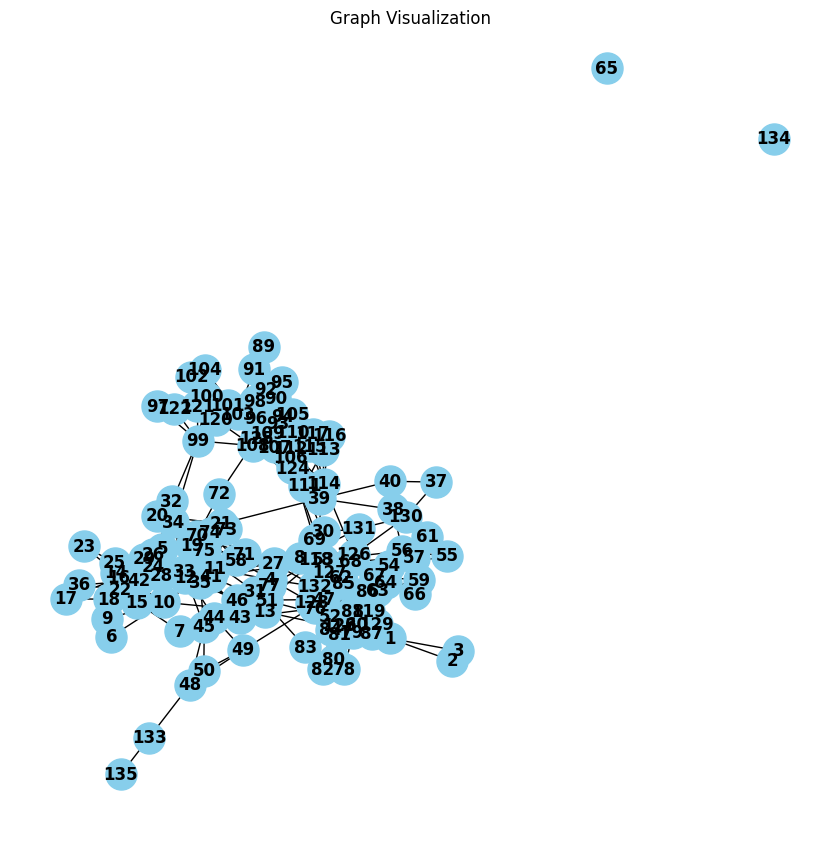

In [96]:
file_path = '26KeroNetwork.net'  
G, node_data = convert_net_to_graph(file_path)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

df_nodes = pd.DataFrame(node_data, columns=['Node', 'Attributes'])
print(df_nodes.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_weight='bold')
plt.title("Graph Visualization")
plt.show()

In [97]:
import numpy as np
from collections import deque

def k_shell_decomposition(G):
    """
    Perform K-shell decomposition to calculate the core value of each node.
    """
    core = {}
    G_copy = G.copy()
    k = 1

    while G_copy.nodes:
        to_remove = [node for node, degree in G_copy.degree() if degree < k]
        G_copy.remove_nodes_from(to_remove)

        if not to_remove:
            break
        
        for node in to_remove:
            core[node] = k

        k += 1

    for node in G_copy.nodes():
        if node not in core:
            core[node] = k

    return core

def calculate_centrality_measures(G):
    """
    Calculate centrality measures for the nodes in the graph.
    We'll use degree centrality here.
    """
    centrality = nx.degree_centrality(G)
    return centrality

def topsis_matrix(G, core, centrality):
    """
    Construct the TOPSIS matrix based on the core and centrality values.
    """
    matrix = []
    for node in G.nodes():
        degree = G.degree(node)
        core_value = core[node]
        centrality_value = centrality[node]
        matrix.append([degree, core_value, centrality_value])

    return np.array(matrix)

def calculate_topsis_scores(matrix):
    """
    Calculate the TOPSIS scores for each node.
    """
    norm_matrix = matrix / np.linalg.norm(matrix, axis=0)

    ideal = np.max(norm_matrix, axis=0)
    anti_ideal = np.min(norm_matrix, axis=0)

    dist_ideal = np.linalg.norm(norm_matrix - ideal, axis=1)
    dist_anti_ideal = np.linalg.norm(norm_matrix - anti_ideal, axis=1)

    scores = dist_anti_ideal / (dist_ideal + dist_anti_ideal)

    return scores

def k_shell_decomposition(G):
    """
    Perform K-shell decomposition to calculate the core value of each node.
    The core value indicates the shell number for each node in the graph.
    """
    core = {}
    G_copy = G.copy()  
    k = 1

    while G_copy.nodes:
        to_remove = [node for node, degree in G_copy.degree() if degree < k]
        if not to_remove:
            break
        
        G_copy.remove_nodes_from(to_remove)

        for node in to_remove:
            core[node] = k

        k += 1

    for node in G_copy.nodes():
        core[node] = k

    return core

def calculate_centrality_measures(G):
    """
    Calculate centrality measures for the nodes in the graph.
    We'll use degree centrality here.
    """
    centrality = nx.degree_centrality(G)
    return centrality

def topsis_matrix(G, core, centrality):
    """
    Construct the TOPSIS matrix based on the core and centrality values.
    """
    matrix = []
    for node in G.nodes():
        degree = G.degree(node)
        core_value = core[node]
        centrality_value = centrality[node]
        matrix.append([degree, core_value, centrality_value])

    return np.array(matrix)

def calculate_topsis_scores(matrix):
    """
    Calculate the TOPSIS scores for each node.
    """
    constant_columns = np.all(matrix == matrix[0, :], axis=0)
    if np.any(constant_columns):
        print("Warning: Constant columns detected, skipping normalization for these columns.")
    matrix = matrix[:, ~constant_columns]

    epsilon = 1e-8
    norm_matrix = matrix / (np.linalg.norm(matrix, axis=0, keepdims=True) + epsilon)

    if np.any(np.isnan(norm_matrix)) or np.any(np.isinf(norm_matrix)):
        print("Normalization issue: matrix contains NaN or Inf values.")
        return np.zeros(matrix.shape[0])

    ideal = np.max(norm_matrix, axis=0)
    anti_ideal = np.min(norm_matrix, axis=0)

    dist_ideal = np.linalg.norm(norm_matrix - ideal, axis=1)
    dist_anti_ideal = np.linalg.norm(norm_matrix - anti_ideal, axis=1)

    dist_ideal[dist_ideal == 0] = epsilon
    dist_anti_ideal[dist_anti_ideal == 0] = epsilon

    scores = dist_anti_ideal / (dist_ideal + dist_anti_ideal)

    return scores

def k_topsis_algorithm(G, k):
    """
    Apply the K-TOPSIS algorithm to select top k influential nodes in the graph.
    """
    core = k_shell_decomposition(G)

    centrality = calculate_centrality_measures(G)
    matrix = topsis_matrix(G, core, centrality)
    scores = calculate_topsis_scores(matrix)
    top_k_nodes = [node for _, node in sorted(zip(scores, G.nodes()), reverse=True)[:k]]

    return top_k_nodes, scores

In [98]:
top_k_topsis_nodes, topsis_scores = k_topsis_algorithm(G, k=5)
print("Top 5 influential nodes based on K-TOPSIS:")
for i, node in enumerate(top_k_topsis_nodes, start=1):
    print(f"{i}. Node {node} with score: {topsis_scores[i-1]:.4f}")

Top 5 influential nodes based on K-TOPSIS:
1. Node 85 with score: 0.2827
2. Node 103 with score: 0.1893
3. Node 12 with score: 0.1893
4. Node 99 with score: 0.3749
5. Node 81 with score: 0.3749


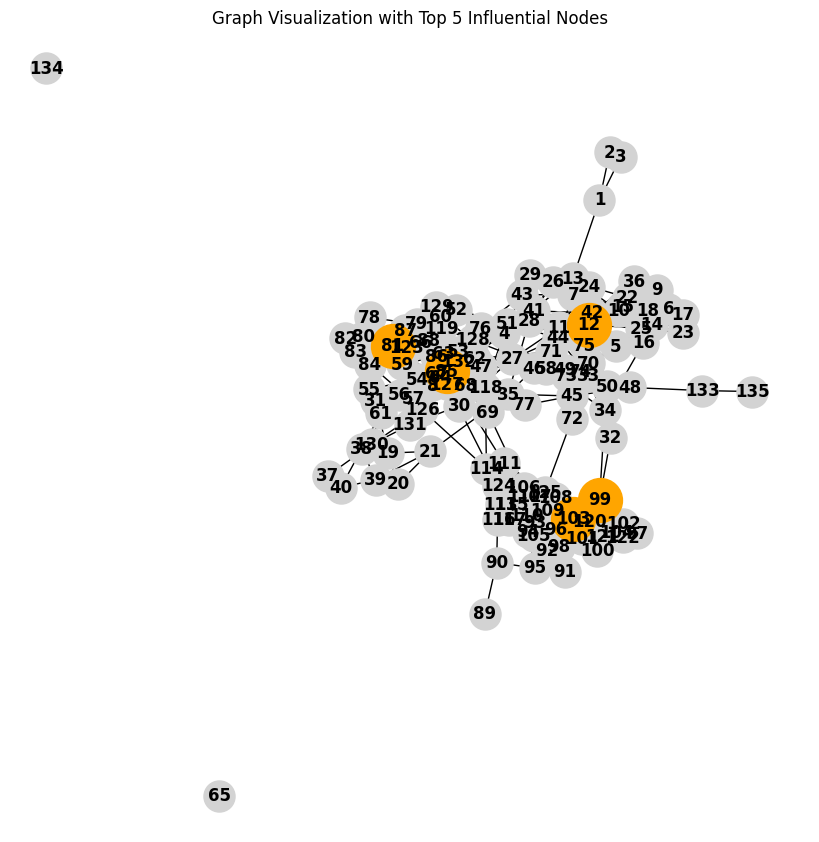

In [99]:
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=500, font_size=12, font_weight='bold')

nx.draw_networkx_nodes(G, pos, nodelist=top_k_topsis_nodes, node_color='orange', node_size=1000)

plt.title("Graph Visualization with Top 5 Influential Nodes")
plt.show()


In [100]:
def top_k_centrality(G, k):
    degree_centrality = nx.degree_centrality(G)
    
    betweenness_centrality = nx.betweenness_centrality(G)
    
    closeness_centrality = nx.closeness_centrality(G)
    
    centralities = {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality
    }
    
    top_k_nodes = {}
    for centrality_name, centrality_values in centralities.items():
        top_k_nodes[centrality_name] = [node for node, _ in sorted(centrality_values.items(), key=lambda item: item[1], reverse=True)[:k]]
    
    top_k_scores = {name: [centrality_values[node] for node in top_k_nodes[name]] for name, centrality_values in centralities.items()}
    
    return top_k_nodes, top_k_scores

top_k_centrality_nodes, centrality_scores = top_k_centrality(G, k=5)

In [103]:
comparison_table = pd.DataFrame({
    'Rank': [i+1 for i in range(5)],
    'K-TOPSIS Node': top_k_topsis_nodes,
    'K-TOPSIS Score': [topsis_scores[i] for i in range(5)],
    'Degree Centrality Node': top_k_centrality_nodes['degree'],
    'Degree Centrality Score': [centrality_scores['degree'][i] for i in range(5)],
    'Betweenness Centrality Node': top_k_centrality_nodes['betweenness'],
    'Betweenness Centrality Score': [centrality_scores['betweenness'][i] for i in range(5)],
    'Closeness Centrality Node': top_k_centrality_nodes['closeness'],
    'Closeness Centrality Score': [centrality_scores['closeness'][i] for i in range(5)],
})

print("\nComparison Table:")
print(comparison_table)


Comparison Table:
   Rank K-TOPSIS Node  K-TOPSIS Score Degree Centrality Node  \
0     1            85        0.282748                     12   
1     2           103        0.189300                     81   
2     3            12        0.189300                     85   
3     4            99        0.374942                     99   
4     5            81        0.374942                    103   

   Degree Centrality Score Betweenness Centrality Node  \
0                 0.089552                          12   
1                 0.082090                          85   
2                 0.082090                          99   
3                 0.082090                          34   
4                 0.082090                          41   

   Betweenness Centrality Score Closeness Centrality Node  \
0                      0.141955                        62   
1                      0.101484                        69   
2                      0.100848                        85   
3  

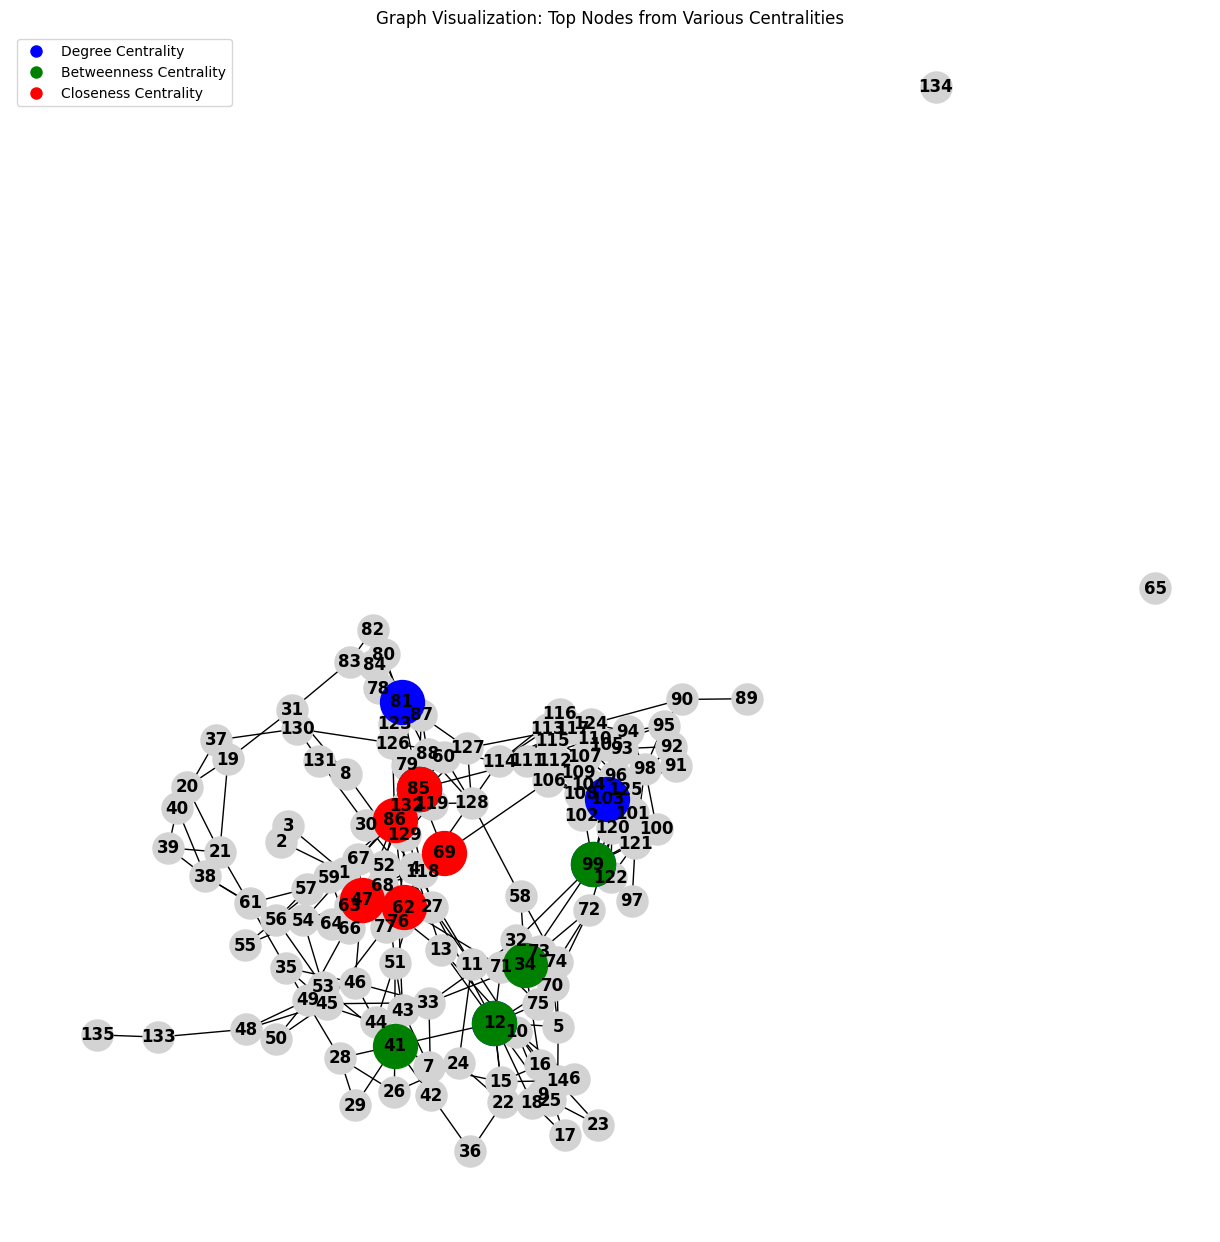

In [104]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=500, font_size=12, font_weight='bold')

nodes_degree_centrality = nx.draw_networkx_nodes(G, pos, nodelist=top_k_centrality_nodes['degree'], node_color='blue', node_size=1000)

nodes_betweenness_centrality = nx.draw_networkx_nodes(G, pos, nodelist=top_k_centrality_nodes['betweenness'], node_color='green', node_size=1000)

nodes_closeness_centrality = nx.draw_networkx_nodes(G, pos, nodelist=top_k_centrality_nodes['closeness'], node_color='red', node_size=1000)

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Degree Centrality', markersize=10, markerfacecolor='blue'),
    plt.Line2D([0], [0], marker='o', color='w', label='Betweenness Centrality', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='Closeness Centrality', markersize=10, markerfacecolor='red')
]

plt.legend(handles=handles, loc='upper left')

plt.title("Graph Visualization: Top Nodes from Various Centralities")
plt.show()


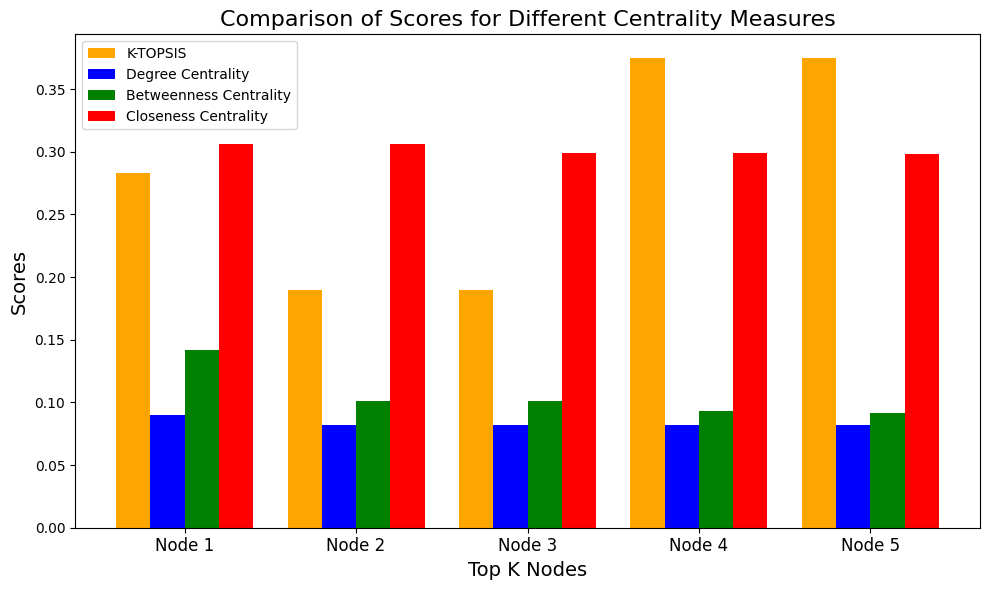

In [105]:
centrality_labels = ['K-TOPSIS', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']
scores = [
    topsis_scores[:5],  
    centrality_scores['degree'][:5], 
    centrality_scores['betweenness'][:5],  
    centrality_scores['closeness'][:5],
]

x = np.arange(5)  
width = 0.2 

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * width, scores[0], width, label='K-TOPSIS', color='orange')
ax.bar(x - 0.5 * width, scores[1], width, label='Degree Centrality', color='blue')
ax.bar(x + 0.5 * width, scores[2], width, label='Betweenness Centrality', color='green')
ax.bar(x + 1.5 * width, scores[3], width, label='Closeness Centrality', color='red')

ax.set_xlabel('Top K Nodes', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Comparison of Scores for Different Centrality Measures', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([f'Node {i+1}' for i in range(5)], fontsize=12)

ax.legend()

plt.tight_layout()
plt.show()

In [106]:
import numpy as np
import scipy.stats as stats
import pandas as pd

scores = {
    'K-TOPSIS': topsis_scores[:5],
    'Degree Centrality': centrality_scores['degree'][:5],
    'Betweenness Centrality': centrality_scores['betweenness'][:5],
    'Closeness Centrality': centrality_scores['closeness'][:5]
}

df_scores = pd.DataFrame(scores)

summary_stats = df_scores.describe().T[['mean', '50%', 'std']]
summary_stats.rename(columns={'50%': 'median'}, inplace=True)

print("Summary Statistics for the Scores:")
print(summary_stats)

f_stat, p_value = stats.f_oneway(df_scores['K-TOPSIS'],
                                  df_scores['Degree Centrality'],
                                  df_scores['Betweenness Centrality'],
                                  df_scores['Closeness Centrality'])

print("\nANOVA Test Results:")
print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")


if p_value < 0.05:
    print("\nThere is a statistically significant difference between the centrality measures.")
    
    pairwise_results = {}
    measures = list(scores.keys())
    
    for i in range(len(measures)):
        for j in range(i + 1, len(measures)):
            t_stat, p_val = stats.ttest_ind(df_scores[measures[i]], df_scores[measures[j]])
            pairwise_results[f"{measures[i]} vs {measures[j]}"] = (t_stat, p_val)
    
    print("\nPairwise t-tests (t-statistic, p-value):")
    for pair, result in pairwise_results.items():
        print(f"{pair}: t-statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

else:
    print("\nNo statistically significant difference between the centrality measures.")

Summary Statistics for the Scores:
                            mean    median       std
K-TOPSIS                0.282247  0.282748  0.092822
Degree Centrality       0.083582  0.082090  0.003337
Betweenness Centrality  0.105876  0.100848  0.020634
Closeness Centrality    0.301595  0.298919  0.003987

ANOVA Test Results:
F-statistic: 28.906, p-value: 0.000

There is a statistically significant difference between the centrality measures.

Pairwise t-tests (t-statistic, p-value):
K-TOPSIS vs Degree Centrality: t-statistic = 4.783, p-value = 0.001
K-TOPSIS vs Betweenness Centrality: t-statistic = 4.148, p-value = 0.003
K-TOPSIS vs Closeness Centrality: t-statistic = -0.466, p-value = 0.654
Degree Centrality vs Betweenness Centrality: t-statistic = -2.385, p-value = 0.044
Degree Centrality vs Closeness Centrality: t-statistic = -93.753, p-value = 0.000
Betweenness Centrality vs Closeness Centrality: t-statistic = -20.825, p-value = 0.000
